🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, I will be going through an example machine learning project with the goal of predicting the sale price of bulldozers

1. Problem Definition

    How well can I predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozer have been sold for?

2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozer competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

-   Train.csv is the training set, which contains data through the end of 2011.
-    Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
-   Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.


3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note**: The goal for most regression evaluation metrics is to minimize the error. For example, the goal for this project will be to build a machine learning model which minimises RMSLE.

4. Features

The key fields are in train.csv are:

    SalesID: the uniue identifier of the sale
    MachineID: the unique identifier of a machine.  A machine can be sold multiple times
    saleprice: what the machine sold for at auction (only provided in train.csv)
    saledate: the date of the sale

Kaggle also provided a Data Dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint

# To see how fast the model executes
import time

In [58]:
# Import training and validation set
# To get rif of the warning, set low_memory=False (Dont minimize the RAM space, just use it all)
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)

In [59]:
# Check on the information type on the project
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [60]:
# Check if there is any null values
df.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

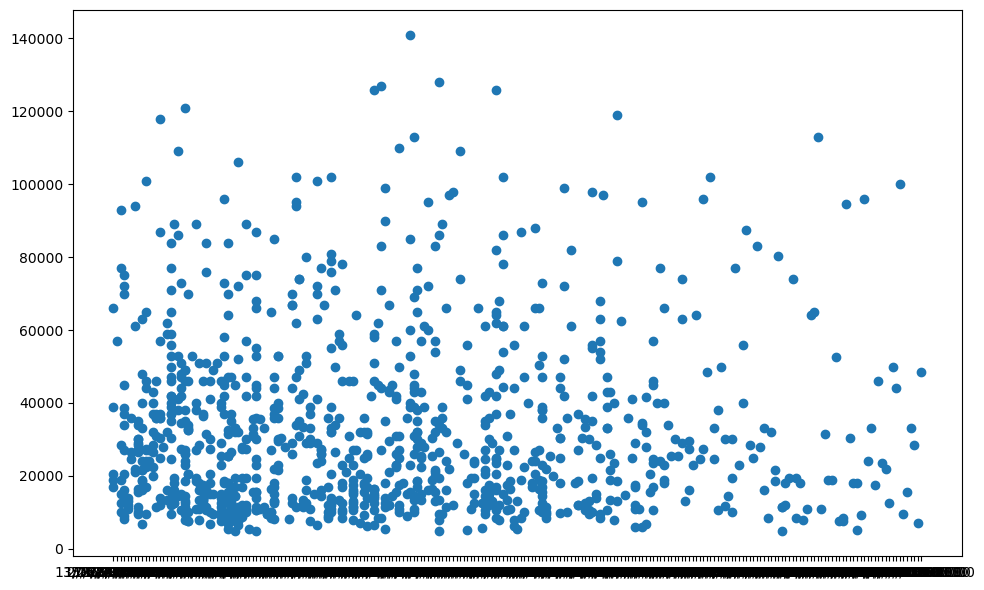

In [61]:
# To visualize the first 1000 sold bulldozer against the sale price just to get some information about the data

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(df.saledate[:1000], df.SalePrice[:1000])
plt.tight_layout()
plt.show()

In [62]:
# The Python Object contains string, will need to properly encode in dates later as this is a time-series object
df.saledate.dtype

dtype('O')

<Axes: ylabel='Frequency'>

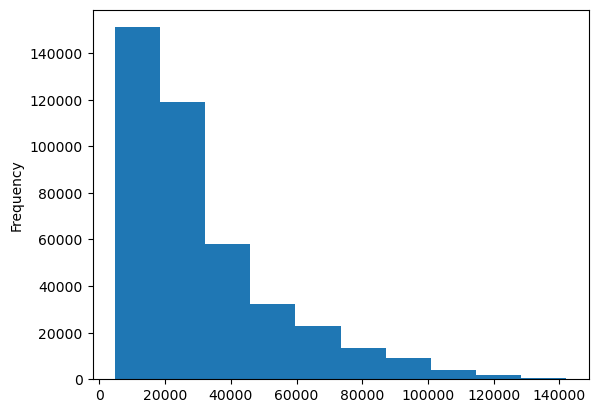

In [63]:
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the 'parse_dates' parameter

Parsing dates with NumPy typically involves converting string representations of dates and times into NumPy's datetime64 data type. This enables efficient date and time calculations within NumPy arrays.


In [64]:
# Import data again and parse the dates

df = pd.read_csv("data/TrainAndValid.csv",
                low_memory=False,
                parse_dates=["saledate"])
df[:1000]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1142566,33000.0,1069733,5428,121,3.0,2005,3759.0,Medium,2009-07-16,...,None or Unspecified,None or Unspecified,Hydraulic,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
996,1142567,62000.0,531918,23162,121,3.0,2005,1290.0,Medium,2007-06-14,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
997,1142568,8000.0,1064508,17472,121,3.0,1998,1865.0,Medium,2005-09-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,1142577,16000.0,1046210,13391,121,3.0,2004,851.0,High,2005-07-28,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [65]:
# Numpy way of saying datetime64[ns]

df.saledate.dtype

dtype('<M8[ns]')

In [66]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

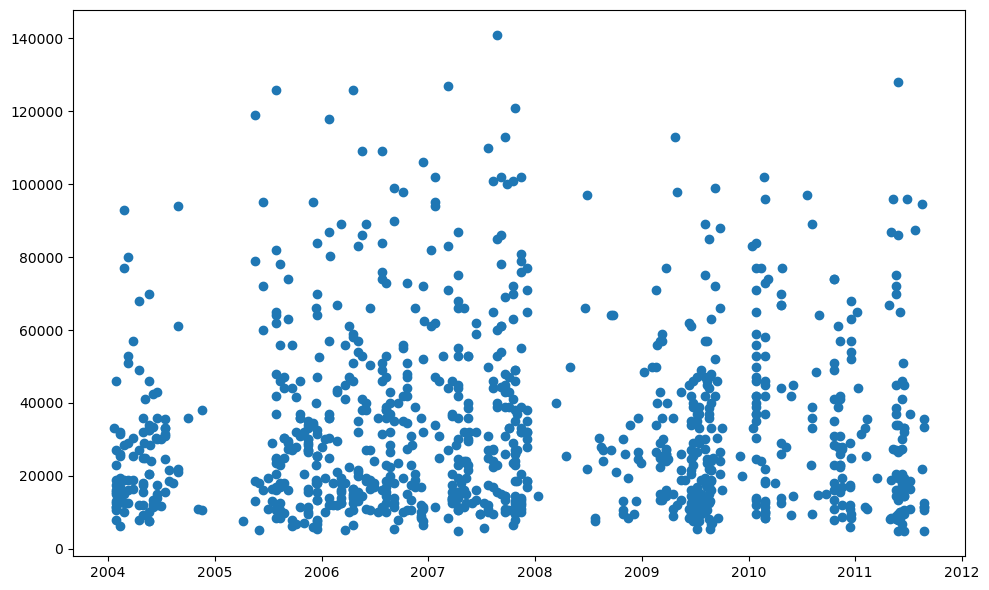

In [67]:
# Now properly plot the scatter plot to see the difference
# Now the scatter plot is properly distributed by the year

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(df.saledate[:1000], df.SalePrice[:1000])
plt.tight_layout()
plt.show()

In [68]:
# To see every column and not being truncated, transpose the axis
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [69]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort Dataframe by saledate

When working with time series data, it's a good idea to sort it by date

In [70]:
# Sort dataframe in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original Dataframe

We make a copy of the original dataframe so when we manipualte the copy, we still have the original data

In [71]:
# Make a copy
df_tmp = df.copy()

In [72]:
df_tmp.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Add datetime parameters for "saledate" column - To be done for every timeseries data

In [73]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [74]:
# Since the proper sales date column has been created, the original saledate column can be dropped

df_tmp.drop("saledate",axis=1, inplace=True)

In [75]:
# Check the values of different columns

df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling

We've done enough EDA (we could always do more), let's start to do some model-drive EDA

In [114]:
# New method of fixing data leakage

# Masking before time-based splitting to mimic real future prediction and avoild look-ahead leakage

train_mask = df_tmp.saleYear < 2012
val_mask = (df_tmp.saleYear == 2012) & (df_tmp.saleMonth <= 4)
test_mask = (df_tmp.saleYear == 2012) & (df_tmp.saleMonth >= 5)

train_df = df_tmp[train_mask]
val_df = df_tmp[val_mask]
test_df = df_tmp[test_mask]

def split_feature(dataframe):
    X = dataframe.drop("SalePrice", axis=1)
    y = dataframe["SalePrice"]

    return X, y
# Build and seperate the features from target so that model only sees predictors during training
X_train, y_train = split_feature(train_df)
X_val, y_val = split_feature(val_df)
X_test, y_test = split_feature(test_df)

# One hot enconding takes too lon, drop high-cardinality labels as they inflate one-hot features and can cause overfitting/memory wastage
# Identify and drop ID-Like Columns
def identify_id_cols(column_name):
    id_list = []

    for label in column_name:
        if label.lower().endswith("id") or label in ["SalesID", "MachineID"]:
            id_list.append(label)
    
    return id_list

def drop_id_cols(dataset, id_cols):
    return dataset.drop(columns=id_cols, errors="ignore")


# Identify numeric / categorical first for right processing steps

def identify_feature_type(dataset):
    num_features = []
    cat_features = []
    for label, content in dataset.items():
        if pd.api.types.is_numeric_dtype(content):
            num_features.append(label)
        else:
            cat_features.append(label)
    
    return num_features, cat_features


# Find high-cardinality category as very large count would explode one-hot dimension. 
def find_high_cardinality(dataset, cat_features):
    threshold=500
    high_card_features = []

    for label in cat_features:
        if dataset[label].nunique() > threshold:
            high_card_features.append(label)
    
    return high_card_features

id_cols = identify_id_cols(X_train.columns)
X_train_s = drop_id_cols(X_train, id_cols)
X_val_s   = drop_id_cols(X_val, id_cols)
X_test_s  = drop_id_cols(X_test, id_cols)

num_features, cat_features = identify_feature_type(X_train_s)

# Find high cardinality from train set
high_card_features = find_high_cardinality(X_train_s, cat_features)

# Drop high-cardinality columns from all splits
X_train_s2 = X_train_s.drop(columns=high_card_features, errors="ignore")
X_val_s2   = X_val_s.drop(columns=high_card_features, errors="ignore")
X_test_s2  = X_test_s.drop(columns=high_card_features, errors="ignore")

# Rebuild the features after dropping them from high_cardinality
num_features, cat_features = identify_feature_type(X_train_s2)

# Diagnostics
print("ID columns dropped:", id_cols)
print("High-cardinality columns dropped:", high_card_features)
print("Final numeric feature count:", len(num_features))
print("Final categorical feature count:", len(cat_features))
print("Train/Val/Test shapes:", X_train_s2.shape, X_val_s2.shape, X_test_s2.shape)

ID columns dropped: ['SalesID', 'MachineID', 'ModelID', 'auctioneerID']
High-cardinality columns dropped: ['fiModelDesc', 'fiBaseModel']
Final numeric feature count: 8
Final categorical feature count: 42
Train/Val/Test shapes: (401125, 50) (11573, 50) (0, 50)


In [1]:
# Create pipeline

def create_pipeline():
    # Replace with median as median is less sensitive to outliers than mean
    num_pipeline=Pipeline([
        ("imputer", SimpleImputer(strategy="median"))
    ])

    # Fill missing with a placeholder than OHE it so that it becomes a binary indicator
    cat_pipeline=Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="_Missing_")),
        ("encoder", OneHotEncoder(handle_unknown="ignore",
                                  sparse_output=False,
                                  dtype=np.float32))
    ])

    # Apply the pipeline and concatenate the results
    preprocessor = ColumnTransformer(transformers=[
        ("cat", cat_pipeline, cat_features),
        ("num", num_pipeline, num_features)
    ])

    # Instantiate the model with limits for a proper baseline
    model = RandomForestRegressor(n_estimators=30,
                                  max_depth=20,
                                  max_samples=10000,
                                  min_samples_leaf=5,
                                  max_features="sqrt",
                                  random_state=42,
                                  n_jobs=-1,
                                  verbose=1)

    model_pipeline=Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("rf", model)
    ])

    return model_pipeline

# Measure the time it needs to execute everything
start = time.time()
model = create_pipeline()
model.fit(X_train_s2, y_train)
print("Fit time (s):", round(time.time()-start, 2))
    

NameError: name 'time' is not defined

# Custom Function for evaliation

In [116]:
def rmsle(y_true, y_pred):
    """
    Calculates the Root Mean Squared Logarithmic Error (RMSLE).

    Args:
        y_true (np.ndarray or list): True target values.
        y_pred (np.ndarray or list): Predicted values.

    Returns:
        float: The RMSLE score.
    """

    # Convert input to Numpy Array for faster computation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred = np.maximum(y_pred, 0)

    # Add 1 to avoid log(0) errors and handle potential negative predictions
    # Predictions should ideally be non-negative for RMSLE to be meaningful
    y_true_log = np.log1p(y_true)
    y_pred_log = np.log1p(y_pred)

    # Calculate the squared difference of the log-transformed values
    squared_log_error = np.square(y_true_log - y_pred_log)

    # Compute the mean of the squared log errors
    mean_squared_log_error = np.mean(squared_log_error)

    # Return the square root to get RMSLE
    result = np.sqrt(mean_squared_log_error)
    return result

def score_summary(model):
    train_pred = model.predict(X_train_s2)
    val_pred = model.predict(X_val_s2)

    scores = {
        "Training MAE": mean_absolute_error(y_train, train_pred),
        "Valid MAE": mean_absolute_error(y_val, val_pred),
        "Training RMSLE": rmsle(y_train, train_pred),
        "Valid RMSLE": rmsle(y_val, val_pred),
        "Valid R^2": r2_score(y_val, val_pred)
    }

    return scores

score_summary(model)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  14 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=24)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  14 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  30 out of  30 | elapsed:    0.0s finished


{'Training MAE': 10217.609240369848,
 'Valid MAE': 11993.081861006774,
 'Training RMSLE': np.float64(0.4402881202544946),
 'Valid RMSLE': np.float64(0.462240953820391),
 'Valid R^2': 0.5892728467992876}

In [79]:
# Training MAE: 8,792 → On average training predictions miss actual sale price by about $8.8K.
# Valid MAE ≈ $10.1K 

# Training vs Validation MAE gap (~1.3K) is modest → limited overfitting.

# Training RMSLE: 0.388 → multiplicative error ≈ e^0.388 - 1 ≈ 47% typical relative miss.
# Validation RMSLE: 0.404 → ≈ 50% relative miss; small increase from train → generalization acceptable.

# Valid R²: 0.701 → Model explains about 70% of the variance in validation prices (solid baseline).

# RandomizedSearchCV Hypertuning

In [ ]:
# Setting the grid
rf_grid = {
    "rf__n_estimators": [30, 50],
    "rf__max_depth": [10, 20],
    "rf__max_samples": np.arange(10000, 100000, 10000),
    "rf__min_samples_split": [2, 5],
    "rf__min_samples_leaf": [1, 3],
    "rf__max_features": ["sqrt"],
}


rs_rf = RandomizedSearchCV(estimator=model,
                           param_distributions=rf_grid,
                           n_iter=4,
                           cv=2,
                           verbose=1,
                           random_state=42,
                           n_jobs=-1)

rs_rf.fit(X_train_s2, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s


In [81]:
# Printing out the best_params

best_params = rs_rf.best_params_
print(best_params)

{'rf__n_estimators': 50, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_samples': np.int64(40000), 'rf__max_features': 'sqrt', 'rf__max_depth': 20}


In [82]:
# Scoring with custom evaluation score
score_summary(rs_rf)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  50 out of  50 | elapsed:    0.0s finished


{'Training MAE': 8381.722368865781,
 'Valid MAE': 9831.944507906202,
 'Training RMSLE': np.float64(0.3730300815579207),
 'Valid RMSLE': np.float64(0.39405197231343453),
 'Valid R^2': 0.718658267132736}

# Parsing in test set

In [90]:
df_test = pd.read_csv("data/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [91]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [92]:
df_test.saledate.dtype

dtype('<M8[ns]')

In [93]:
def datatime_features(dataframe):
    for label in ["saleYear", "saleMonth", "saleDay", "saleDayOfWeek", "saleDayOfYear"]:
        if label not in dataframe:
            dataframe["saleYear"] = dataframe.saledate.dt.year
            dataframe["saleMonth"] = dataframe.saledate.dt.month
            dataframe["saleDay"] = dataframe.saledate.dt.day
            dataframe["saleDayOfWeek"] = dataframe.saledate.dt.dayofweek
            dataframe["saleDayOfYear"] = dataframe.saledate.dt.dayofyear
            return

def preprocess_test_data(df_test, id_cols, high_card_features):
    df_tmp = df_test.copy()
    datatime_features(df_tmp)
    X_test = drop_id_cols(df_tmp, id_cols)
    X_test = X_test.drop(columns=high_card_features, errors="ignore")
    return X_test

X_test= preprocess_test_data(df_test, id_cols, high_card_features)

In [94]:
X_test.head()

,datasource,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,121,1999,3688.0,Low,2012-05-03,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,...,NaN,NaN,NaN,NaN,NaN,2012,5,3,3,124
1,121,1000,28555.0,High,2012-05-10,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,...,NaN,NaN,NaN,Standard,Conventional,2012,5,10,3,131
2,121,2004,6038.0,Medium,2012-05-10,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",...,NaN,NaN,NaN,NaN,NaN,2012,5,10,3,131
3,121,2006,8940.0,High,2012-05-10,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",...,NaN,NaN,NaN,NaN,NaN,2012,5,10,3,131
4,121,2005,2286.0,Low,2012-05-10,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,5,10,3,131


Exception ignored in: <function ResourceTracker.__del__ at 0x75e048d7f100>
Traceback (most recent call last):
  File "/home/axlee/Desktop/Bluebook_Bulldozer_Price_Regression/env/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/axlee/Desktop/Bluebook_Bulldozer_Price_Regression/env/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/axlee/Desktop/Bluebook_Bulldozer_Price_Regression/env/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7a9a80f97100>
Traceback (most recent call last):
  File "/home/axlee/Desktop/Bluebook_Bulldozer_Price_Regression/env/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/axlee/Desktop/Bluebook_Bulldozer_Price_Regression/env/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/axlee/Desk

In [95]:
# Make predictions
test_preds = rs_rf.predict(X_test)
test_preds

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  50 out of  50 | elapsed:    0.0s finished


array([22042.2302132 , 28859.1173551 , 51813.80311549, ...,
       13292.08478877, 14555.0198966 , 20773.34969271], shape=(12457,))

In [96]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,22042.230213
1,1227844,28859.117355
2,1227847,51813.803115
3,1227848,69735.772862
4,1227863,31056.781720
...,...,...
12452,6643171,30375.959639
12453,6643173,14110.917543
12454,6643184,13292.084789
12455,6643186,14555.019897


In [98]:
# Export prediction data
df_preds.to_csv("data/test_predictions.csv", index=False)

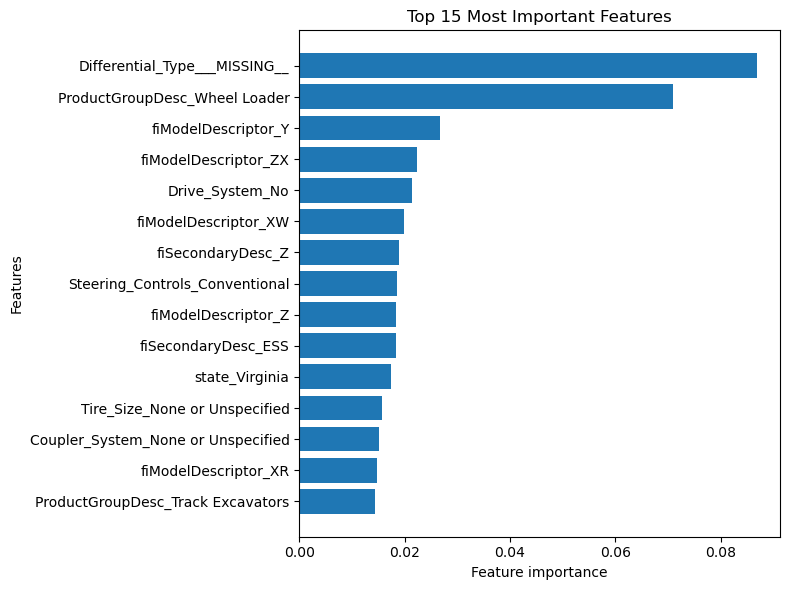

In [111]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=15):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.set_title(f"Top {n} Most Important Features")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

# Get feature importances and feature names from the tuned model
importances = rs_rf.best_estimator_.named_steps["rf"].feature_importances_
preprocessor = rs_rf.best_estimator_.named_steps["preprocessor"]

# Numeric feature names
num_features_names = preprocessor.transformers_[1][2]
# Categorical feature names after OHE
cat_features_names = preprocessor.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(preprocessor.transformers_[0][2])
# Combine all feature names
feature_names = list(num_features_names) + list(cat_features_names)

# Plot top 15 features
plot_features(feature_names, importances, n=15)

NameError: name 'plt' is not defined

# Things to do

-   Plot the distribution of Predicted Sale Price
-   Plot Predicted Sale Price vs SalesID
-   Compare the Distribution to Training Set and Validation Set with Histogram